## Basic Encoder Decoder Architecture
**Training** : During training we train the encoder and decoder such that they work together to create a context between input and output

**Inference**: After learning how to create the context, they can work together to predict the output

**Encode all decode one at a time** : Mostly encoder reads all the input sequence and create a representation vector. Decoder use this and previously decoded result to create new output step by step.

**Teacher Forcing**: During training decoder receives the correct output from the training set as the previously decoded result to prediict the next output. However during inference decoder receives the previously decoded result to predict the next output. Teacher forcing improves training process.

In [1]:
import numpy as np

In [8]:
# generate a sequence of random integers
def generate_sequence(length, n_unique):
	return [np.random.randint(1, n_unique-1) for _ in range(length)]

# one hot encode sequence
def one_hot_encode(sequence, n_unique):
	encoding = list()
	for value in sequence:
		vector = [0 for _ in range(n_unique)]
		vector[value] = 1
		encoding.append(vector)
	return np.array(encoding)

# decode a one hot encoded string
def one_hot_decode(encoded_seq):
	return [np.argmax(vector) for vector in encoded_seq]

# prepare data for the LSTM
def get_reversed_pairs(time_steps,vocabulary_size,verbose= False):
	# generate random sequence
	sequence_in = generate_sequence(time_steps, vocabulary_size)
	sequence_out = sequence_in[::-1]
	
	# one hot encode
	X = one_hot_encode(sequence_in, vocabulary_size)
	y = one_hot_encode(sequence_out, vocabulary_size)
	# reshape as 3D
	X = X.reshape((1, X.shape[0], X.shape[1]))
	y = y.reshape((1, y.shape[0], y.shape[1]))

	if(verbose):
		print("\nNotes:")
		print('1. For each input sequence (X), selecting ',time_steps,
		      ' random numbers between 1 (inclusive) and ',
		      vocabulary_size, ' (exclusive) ')
		print("2. 0 is reserved as the SART Symbol")
	  
		print('\nA sample X ')
		print('X=%s' % (one_hot_decode(X[0])))
		print('\nreversed input sequence (X) is the output sequence (y) ')
		print('y=%s' % (one_hot_decode(y[0])))
	
		print('\nEach input and output sequences are converted one_hot_encoded format in ',
		      vocabulary_size,' dimensions')
		print('X=%s' % (X[0]))
		print('y=%s' % (y[0]))
	return X,y


def create_dataset(train_size, test_size, time_steps,vocabulary_size, verbose= False):
	pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(train_size)]
	pairs=np.array(pairs).squeeze()
	X_train = pairs[:,0]
	y_train = pairs[:,1]
	pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(test_size)]
	pairs=np.array(pairs).squeeze()
	X_test = pairs[:,0]
	y_test = pairs[:,1]	

	if(verbose):
		print('\nGenerated sequence datasets as follows (batch_size,time_steps, features)')
		print('X_train.shape: ', X_train.shape,'y_train.shape: ', y_train.shape)
		print('X_test.shape: ', X_test.shape,'y_test.shape: ', y_test.shape)
	
	return X_train, y_train, X_test, 	y_test

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

In [6]:
N_TIMESTEPS_IN = 4 # for our sequence length 4
N_FEATURES = 10 # for our vocab size of 10 length

In [9]:
X, y = get_reversed_pairs(N_TIMESTEPS_IN, N_FEATURES, verbose=True)


Notes:
1. For each input sequence (X), selecting  4  random numbers between 1 (inclusive) and  10  (exclusive) 
2. 0 is reserved as the SART Symbol

A sample X 
X=[1, 6, 5, 6]

reversed input sequence (X) is the output sequence (y) 
y=[6, 5, 6, 1]

Each input and output sequences are converted one_hot_encoded format in  10  dimensions
X=[[0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]]
y=[[0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]]


In [10]:
TRAIN_SIZE = 2000
TEST_SIZE = 200

In [11]:
X_train, y_train, X_test, y_test = create_dataset(TRAIN_SIZE, TEST_SIZE, N_TIMESTEPS_IN, N_FEATURES, verbose=True)


Generated sequence datasets as follows (batch_size,time_steps, features)
X_train.shape:  (2000, 4, 10) y_train.shape:  (2000, 4, 10)
X_test.shape:  (200, 4, 10) y_test.shape:  (200, 4, 10)


In [14]:
np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)

In [17]:
X_train = np.load('./data/X_train.npy')
y_train = np.load('./data/y_train.npy')
X_test = np.load('./data/X_test.npy')
y_test = np.load('./data/y_test.npy')

In [18]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2000, 4, 10), (2000, 4, 10), (200, 4, 10), (200, 4, 10))

In [20]:
X_train[0], y_train[0] # should be reversed number, they are encoded in OHE

(array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]]),
 array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]]))

## LSTM Concept

### In LSTM there are 3 important parameters:

1. **UNITS** : Dimensionality of the output space
2. **Return Sequences** : Whether to return the last output only or the intermediate state at each `timestep`.
3. **Return State** : Whether to return the last state in addition to the output.

### Training Flow
1. Get the context vector of the LSTM by return state = True and input as our X_feature which is the original list of number so that we get the last hidden state and last cell state from the encoder.
2. The representation vector becomes the input state of the decoder.
3. And now the decoder takes input as the revered list as its input

In [22]:
LATENT_DIM = 16 # representation vector size

### NOTE: Encoder-Decoder
- `Context-Vector Representation` is the Last Hidden State and Cell State of the Encoder LSTM
- `return_states=True` returns the Last Hidden State, Last Hidden State and Last Cell State
- We can ignore any one Last Hidden State since we need only one Last Hidden State
- The output is the `Representation Vector`
- By using the ouput of Encoder, we set the initial state of Decoder
- Now Decoder will start with the last state of the Encoder

## Encoder

In [ ]:
import tensorflow as tf

In [29]:
# Encoder Input Layer (4, 10)
encoder_inputs = tf.keras.layers.Input(shape=(N_TIMESTEPS_IN, N_FEATURES), name="encoder_inputs")
# Encoder LSTM Layer
encoder_lstm = tf.keras.layers.LSTM(LATENT_DIM, return_state=True, name="lstm")
# Encoder LSTM Output
encoder_outputs, encoder_hidden_state, encoder_cell_state = encoder_lstm(encoder_inputs)

states = [encoder_hidden_state, encoder_cell_state]

In [ ]:
encoder_model = tf.keras.Model(encoder_inputs, states)
representation_vector = encoder_model(X) # sample example as input

In [33]:
print('X.shape: ', X.shape)
print('numberOfLSTMunits: ', LATENT_DIM)
print('last hidden states',representation_vector[0].numpy().shape)
print('last cell states',representation_vector[1].numpy().shape)

X.shape:  (1, 4, 10)
numberOfLSTMunits:  16
last hidden states (1, 16)
last cell states (1, 16)


## Decoder Model

In [34]:
decoder_inputs = tf.keras.layers.Input(shape=(1, N_FEATURES), name="decoder_inputs")
decoder_lstm = tf.keras.layers.LSTM(LATENT_DIM, return_sequences=True, return_state=True, name="lstm")
decoder_dense = tf.keras.layers.Dense(N_FEATURES, activation='softmax', name="decoder_dense")

outputs_decoder, decoder_h_state, decoder_c_state = decoder_lstm(decoder_inputs, initial_state=states)

In [35]:
decoder_lstm.output

[<KerasTensor shape=(None, 1, 16), dtype=float32, sparse=False, name=keras_tensor_6>,
 <KerasTensor shape=(None, 16), dtype=float32, sparse=False, name=keras_tensor_7>,
 <KerasTensor shape=(None, 16), dtype=float32, sparse=False, name=keras_tensor_8>]

In [36]:
print('\nIn raw format:')
print('X=%s' % (one_hot_decode(X[0])))
print('y=%s' % (one_hot_decode(y[0])))
print('\nIn one_hot_encoded format:')
print('X=%s' % (X[0]))
print('y=%s' % (y[0]))


In raw format:
X=[1, 6, 5, 6]
y=[6, 5, 6, 1]

In one_hot_encoded format:
X=[[0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]]
y=[[0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]]


## Encoder Decoder
- Encoder get the input and then get the representation vector
- Then the Decoder will get the initial state
- Decoder produce outout one by one
- The initial input to the decoder is the start token `<SOS>`
- Using initial context and the initial input the decoder will generate/predict the first output
- For the next time step, decoder will use its `own hidden and cell state` as its state and generated output at the previous time step as input
- This will work in loop for the `max sequence length` or `<EOS>` is reached.

In [37]:
from IPython.display import Image
Image(url='https://nextjournal.com/data/Qmc1KsqbPiPqP6dyA3niRnZ4StznJzx28d9FRdipYEZJx4?filename=Seq2Seq%20Model%20Animation.gif&content-type=image/gif', width = 600, height = 400)

In [60]:
BATCH_SIZE = 10

### Coding Full Encoder Decoder Model

In [104]:
# encoder
encoder_inputs = tf.keras.layers.Input(shape=(N_TIMESTEPS_IN, N_FEATURES), name="encoder_inputs")
encoder_lstm = tf.keras.layers.LSTM(LATENT_DIM, return_state=True, name="lstm_enc")
_, encoder_hidden_state, encoder_cell_state = encoder_lstm(encoder_inputs)

# context representation vector
states = [encoder_hidden_state, encoder_cell_state]

In [105]:
# decoder layer
decoder_lstm = tf.keras.layers.LSTM(LATENT_DIM, return_sequences=True, return_state=True, name="lstm_dec")
decoder_dense = tf.keras.layers.Dense(N_FEATURES, activation="softmax", name="dense_layer")

Here we get the output from decoder lstm (1, 4, 16) due to the return sequences = True and after dense layer the output will be (1, 4, 10)

In [106]:
decoder_input_data = np.zeros((BATCH_SIZE, 1, N_FEATURES)) # (4, 1, 10) all zero
# set the first input as the start symbol
decoder_input_data[:, 0, 0] = 1 # (4, 1, 10) all zero except the first element
# for each data [1 0 0 0 0 0 0 0 0 0] as the initial input data

In [107]:
decoder_input_data

array([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])

In [108]:
inputs = decoder_input_data
all_outputs = list()

for _ in range(N_TIMESTEPS_IN):
    outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)
    outputs = decoder_dense(outputs)
    all_outputs.append(outputs)
    inputs = outputs
    states = [state_h, state_c]

In [109]:
t_1 = tf.constant([[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]], dtype=tf.float32)
t_2 = tf.constant([[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]]], dtype=tf.float32)
t_3 = tf.constant([[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]]], dtype=tf.float32)

t_123_ = tf.concat([t_1, t_2, t_3], axis=0) # (3, 1, 10)
t_123 = tf.concat([t_1, t_2, t_3], axis=1) # (1, 3, 10)
t_123__ = tf.concat([t_1, t_2, t_3], axis=2) # (1, 1, 30)

t_123_.shape, t_123.shape, t_123__.shape

(TensorShape([3, 1, 10]), TensorShape([1, 3, 10]), TensorShape([1, 1, 30]))

In [110]:
from keras.layers import Concatenate

decoder_outputs = Concatenate(axis=1)(all_outputs) # from (10, 1, 10) * 4 to (10, 4, 10)

In [111]:
all_outputs

[<KerasTensor shape=(10, 1, 10), dtype=float32, sparse=False, name=keras_tensor_103>,
 <KerasTensor shape=(10, 1, 10), dtype=float32, sparse=False, name=keras_tensor_107>,
 <KerasTensor shape=(10, 1, 10), dtype=float32, sparse=False, name=keras_tensor_111>,
 <KerasTensor shape=(10, 1, 10), dtype=float32, sparse=False, name=keras_tensor_115>]

In [112]:
decoder_outputs

<KerasTensor shape=(10, 4, 10), dtype=float32, sparse=False, name=keras_tensor_116>

In [113]:
encoder_decoder_model = tf.keras.Model(encoder_inputs, decoder_outputs, name="model0")

In [114]:
encoder_decoder_model.summary()

Model: "model0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 4, 10)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_enc (LSTM)     │ [(None, 16),      │      1,728 │ encoder_inputs[0… │
│                     │ (None, 16),       │            │                   │
│                     │ (None, 16)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_dec (LSTM)     │ [(10, 1, 16),     │      1,728 │ lstm_enc[0][1],   │
│                     │ (10, 16), (10,    │            │ lstm_enc[0][2],   │
│                     │ 16)]              │            │ dense_layer[0][0… │
│                     │                   │            │ lstm_dec[0][1],   │
│                     │                   │            │ lstm_dec[0][2],   │
│                     │                   │            │ dense_layer[1][0… │
│                     │                   │            │ lstm_dec[1][1],   │
│                     │                   │            │ lstm_dec[1][2],   │
│                     │                   │            │ dense_layer[2][0… │
│                     │                   │            │ lstm_dec[2][1],   │
│                     │                   │            │ lstm_dec[2][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_layer (Dense) │ (10, 1, 10)       │        170 │ lstm_dec[0][0],   │
│                     │                   │            │ lstm_dec[1][0],   │
│                     │                   │            │ lstm_dec[2][0],   │
│                     │                   │            │ lstm_dec[3][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (10, 4, 10)       │          0 │ dense_layer[0][0… │
│ (Concatenate)       │                   │            │ dense_layer[1][0… │
│                     │                   │            │ dense_layer[2][0… │
│                     │                   │            │ dense_layer[3][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,626 (14.16 KB)

 Trainable params: 3,626 (14.16 KB)

 Non-trainable params: 0 (0.00 B)

In [115]:
encoder_decoder_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [116]:
model_history = encoder_decoder_model.fit(X_train, y_train  , epochs=100, batch_size=BATCH_SIZE, validation_split=0.2)

Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.1638 - loss: 2.2356 - val_accuracy: 0.2937 - val_loss: 2.0229
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3360 - loss: 1.9308 - val_accuracy: 0.3569 - val_loss: 1.6919
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3854 - loss: 1.6255 - val_accuracy: 0.3944 - val_loss: 1.5340
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4123 - loss: 1.4950 - val_accuracy: 0.3988 - val_loss: 1.4442
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4146 - loss: 1.4338 - val_accuracy: 0.4156 - val_loss: 1.3826
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4274 - loss: 1.3597 - val_accuracy: 0.4356 - val_loss: 1.3280
Epoch 7/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4443 - loss: 1.3050 - val_accuracy: 0.4544 - val_loss: 1.2750
Epoch 8/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4717 - loss: 1.2435 - val_accu

In [118]:
import matplotlib.pyplot as plt

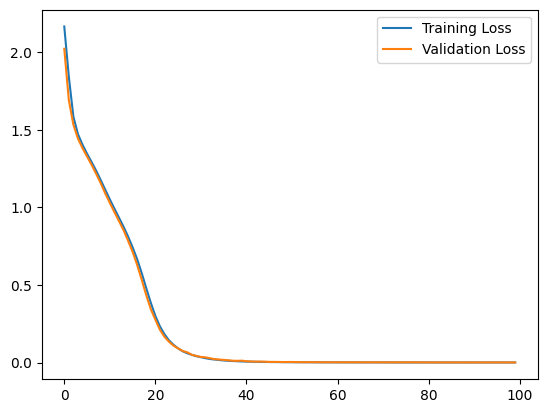

In [119]:
plt.plot(model_history.history["loss"], label="Training Loss")
plt.plot(model_history.history["val_loss"], label="Validation Loss")
plt.legend()

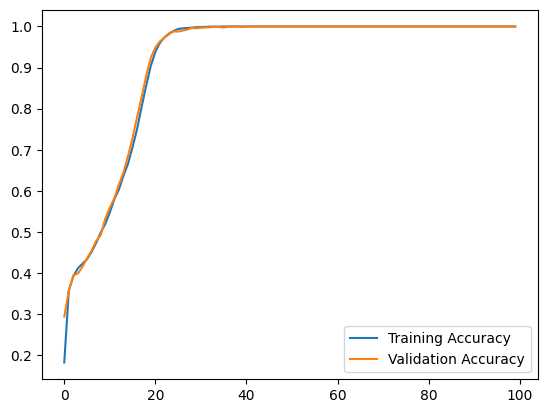

In [120]:
plt.plot(model_history.history["accuracy"], label="Training Accuracy")
plt.plot(model_history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()

## Overall flow for inference

In [138]:
# prepare the input sequence for the model
input_sequence = [1, 2, 3, 9]
# one hot encode the input sequence
encoded_sequence = one_hot_encode([1, 2, 3, 9], 10)
# convert to tensor format
encoded_sequence = np.array(encoded_sequence).reshape(1, 4, 10)

encoded_sequence


array([[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]])

In [139]:
# here we will extract the encoder part from the trained model
_, h_state, c_state = encoder_lstm(encoder_inputs)

In [140]:
representation_vector_inference = [h_state, c_state]

representation_vector_inference

[<KerasTensor shape=(None, 16), dtype=float32, sparse=False, name=keras_tensor_134>,
 <KerasTensor shape=(None, 16), dtype=float32, sparse=False, name=keras_tensor_135>]

In [162]:
decoder_input_initial = tf.constant([[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]], dtype=tf.float32)
decoder_input_initial.shape

TensorShape([1, 1, 10])

In [158]:
decoder_lstm_output, decoder_h_state, decoder_c_state = decoder_lstm(decoder_input_initial, initial_state=representation_vector_inference)

decoder_lstm_output

<KerasTensor shape=(1, 1, 16), dtype=float32, sparse=False, name=keras_tensor_141>

In [159]:
first_sequence_prediction = decoder_dense(decoder_lstm_output)

first_sequence_prediction

<KerasTensor shape=(1, 1, 10), dtype=float32, sparse=False, name=keras_tensor_144>

In [165]:
# running the inference on encoder decoder is a bit tricky as we need to run the decoder multiple times and get make the model different for inference

## Building Inference Model

In [168]:
# take the encoder input and send it to the encoder model to get the hidden and cell states
input_encoder_inference = tf.keras.layers.Input(shape=(N_TIMESTEPS_IN, N_FEATURES), name="encoder_inputs_inference")
encoder_lstm_inference = tf.keras.layers.LSTM(LATENT_DIM, return_state=True, name="lstm_enc_inference")
_, encoder_hidden_state_inference, encoder_cell_state_inference = encoder_lstm_inference(input_encoder_inference)

# now the decoder model will take them as the initial state and the initial input as the start symbol
decoder_lstm_inference = tf.keras.layers.LSTM(LATENT_DIM, return_sequences=True, return_state=True, name="lstm_dec_inference")
decoder_dense_inference = tf.keras.layers.Dense(N_FEATURES, activation="softmax", name="dense_layer_inference")

decoder_input_data_inference = np.zeros((1, 1, N_FEATURES)) # (1, 1, 10) all zero
decoder_input_data_inference[:, 0, 0] = 1 # (1, 1, 10) all zero except the first element

decoder_output_inference, decoder_h_inference, decoder_c_inferece = decoder_lstm_inference(decoder_input_data_inference, initial_state=[encoder_hidden_state_inference, encoder_cell_state_inference])

predictions_1 = decoder_dense_inference(decoder_output_inference)

model_inference = tf.keras.Model(input_encoder_inference, predictions_1)

model_inference.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs_inf… │ (None, 4, 10)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_enc_inference  │ [(None, 16),      │      1,728 │ encoder_inputs_i… │
│ (LSTM)              │ (None, 16),       │            │                   │
│                     │ (None, 16)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_dec_inference  │ [(1, 1, 16), (1,  │      1,728 │ lstm_enc_inferen… │
│ (LSTM)              │ 16), (1, 16)]     │            │ lstm_enc_inferen… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_layer_infere… │ (1, 1, 10)        │        170 │ lstm_dec_inferen… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,626 (14.16 KB)

 Trainable params: 3,626 (14.16 KB)

 Non-trainable params: 0 (0.00 B)

In [181]:
pred_label = model_inference.predict(encoded_sequence).argmax(axis=-1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [185]:
# In this way we run inference for 4 times for our sequence length
pred_label[0]

array([4], dtype=int64)

In [186]:
model_inference.predict(np.array([[[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]]])) # because we got prediction 4th element

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


array([[[0.08911821, 0.09268753, 0.11050936, 0.1060815 , 0.11759365,
         0.10055725, 0.09925769, 0.08779484, 0.10018121, 0.09621883]]],
      dtype=float32)

## Training with Teacher Forcing

In [210]:
encoder_inputs = tf.keras.layers.Input(shape=(N_TIMESTEPS_IN, N_FEATURES), name="encoder_inputs_")
encoder_lstm = tf.keras.layers.LSTM(LATENT_DIM, return_state=True, name="lstm_enc")
_, encoder_hidden_state, encoder_cell_state = encoder_lstm(encoder_inputs)

states = [encoder_hidden_state, encoder_cell_state]

decoder_inputs = tf.keras.layers.Input(shape=(None, N_FEATURES), name="decoder_inputs")
decoder_lstm = tf.keras.layers.LSTM(LATENT_DIM, return_sequences=True, return_state=True, name="lstm_dec")

outputs_decoder, decoder_h_state, decoder_c_state = decoder_lstm(decoder_inputs, initial_state=states)

decoder_dense = tf.keras.layers.Dense(N_FEATURES, activation='softmax', name="decoder_dense_")
decoder_outputs = decoder_dense(outputs_decoder) # take (10, 1, 10) i.e get all the timestep hiddenstate in decoder state

encoder_decoder_model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs, name="model0")

In [211]:
encoder_decoder_model.summary()

Model: "model0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs_     │ (None, 4, 10)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, None, 10)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_enc (LSTM)     │ [(None, 16),      │      1,728 │ encoder_inputs_[… │
│                     │ (None, 16),       │            │                   │
│                     │ (None, 16)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_dec (LSTM)     │ [(None, None,     │      1,728 │ decoder_inputs[0… │
│                     │ 16), (None, 16),  │            │ lstm_enc[0][1],   │
│                     │ (None, 16)]       │            │ lstm_enc[0][2]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense_      │ (None, None, 10)  │        170 │ lstm_dec[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,626 (14.16 KB)

 Trainable params: 3,626 (14.16 KB)

 Non-trainable params: 0 (0.00 B)

In [212]:
encoder_decoder_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [213]:
#@title Functions to generate Seq2Seq Dataset, one hot encode / decode Input & Output Sequences


# generate a sequence of random integers
def generate_sequence(length, n_unique):
	return [np.random.randint(1, n_unique-1) for _ in range(length)]

# one hot encode sequence
def one_hot_encode(sequence, n_unique):
	encoding = list()
	for value in sequence:
		vector = [0 for _ in range(n_unique)]
		vector[value] = 1
		encoding.append(vector)
	return np.array(encoding)

# decode a one hot encoded string
def one_hot_decode(encoded_seq):
  return [np.argmax(vector) for vector in encoded_seq]

  # prepare encoder data for the Encoder-Decoder training
def get_encoder_triple(time_steps,vocabulary_size,verbose= False):
  # generate random sequence
  sequence_in = generate_sequence(time_steps, vocabulary_size)

  encoder_in = sequence_in.copy()

  decoder_out = sequence_in[::-1]
  
  decoder_in = decoder_out.copy()
  decoder_in.insert(0,0)
  decoder_in.pop()

  # one hot encode
  X_encoder_in = one_hot_encode(encoder_in, vocabulary_size)
  X_decoder_in = one_hot_encode(decoder_in, vocabulary_size)
  y_decoder_out = one_hot_encode(decoder_out, vocabulary_size)
  # reshape as 3D
  X_encoder_in = X_encoder_in.reshape((1, X_encoder_in.shape[0], X_encoder_in.shape[1]))
  X_decoder_in = X_decoder_in.reshape((1, X_decoder_in.shape[0], X_decoder_in.shape[1]))
  y_decoder_out = y_decoder_out.reshape((1, y_decoder_out.shape[0], y_decoder_out.shape[1]))

  if(verbose):
    print('\nSample X_encoder_in X_decoder_in and y_decoder_out')
    print('\nIn raw format:')
    print('X_encoder_in=%s, X_decoder_in=%s, y_decoder_out=%s' % 
          (one_hot_decode(X_encoder_in[0]), one_hot_decode(X_decoder_in[0]), 
           one_hot_decode(y_decoder_out[0])))
    print('\nIn one_hot_encoded format:')
    print('X_encoder_in=%s' % (X_encoder_in[0]))
    print('X_decoder_in=%s' % (X_decoder_in[0]))
    print('y_decoder_out=%s' % (y_decoder_out[0]))
  return [np.array(X_encoder_in), np.array(X_decoder_in), np.array(y_decoder_out)]


def create_encoder_dataset(train_size, test_size, time_steps,vocabulary_size, verbose= False):

  X_encoder_in = list()
  X_decoder_in = list()
  y_decoder_out = list()

  for _ in range(train_size):
    triple=get_encoder_triple(time_steps,vocabulary_size) 
    X_encoder_in.append(triple[0])
    X_decoder_in.append(triple[1])
    y_decoder_out.append(triple[2])

  X_encoder_in= np.array(X_encoder_in).squeeze()
  X_decoder_in= np.array(X_decoder_in).squeeze()
  y_decoder_out= np.array(y_decoder_out).squeeze()
  if(verbose):
    print('\nGenerated sequence datasets as follows')
    print('X_encoder_in.shape: ', X_encoder_in.shape)
    print('X_decoder_in.shape: ', X_decoder_in.shape)
    print('y_decoder_out.shape: ', y_decoder_out.shape)
    print('Sample sequences in raw format:')
    
    print('X_encoder_in: \n', one_hot_decode(X_encoder_in[0]))
    print('X_decoder_in: \n', one_hot_decode(X_decoder_in[0]))
    print('y_decoder_out: \n',one_hot_decode(y_decoder_out[0]))

    print('Sample sequences in one-hot encoded format:')
    print('X_encoder_in: \n', X_encoder_in[0])
    print('X_decoder_in: \n', X_decoder_in[0])
    print('y_decoder_out: \n', y_decoder_out[0])

  return X_encoder_in,X_decoder_in, y_decoder_out

## Get the train data for Teacher Forcing

In [214]:
encoder_input_data, decoder_input_data, decoder_predicted_data=\
create_encoder_dataset(TRAIN_SIZE, TEST_SIZE, N_TIMESTEPS_IN,N_FEATURES , verbose=True)



Generated sequence datasets as follows
X_encoder_in.shape:  (2000, 4, 10)
X_decoder_in.shape:  (2000, 4, 10)
y_decoder_out.shape:  (2000, 4, 10)
Sample sequences in raw format:
X_encoder_in: 
 [4, 7, 3, 8]
X_decoder_in: 
 [0, 8, 3, 7]
y_decoder_out: 
 [8, 3, 7, 4]
Sample sequences in one-hot encoded format:
X_encoder_in: 
 [[0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]]
X_decoder_in: 
 [[1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]]
y_decoder_out: 
 [[0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0 0]]


Start Sequence : 0
Stop Sequence: First Number of the list i.e [1, 2, 3, 4] -> 1 is the stop sequence

In [215]:
from tensorflow.keras.callbacks import EarlyStopping

In [216]:
#@title Function to Train & Test  given model (Early Stopping monitor 'val_loss')
def train_test(model, X_train, y_train , X_test, 	y_test, epochs=500, batch_size=32, patience=5,verbose=0):
	# patient early stopping
	#es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1, patience=20)
	es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
	# train model
	print('training for ',epochs,' epochs begins with EarlyStopping(monitor= val_loss, patience=',patience,')....')
	history=model.fit(X_train, y_train, validation_split= 0.1, epochs=epochs,batch_size=batch_size, verbose=verbose, callbacks=[es])
	print(epochs,' epoch training finished...')

	# report training
	# list all data in history
	#print(history.history.keys())
	# evaluate the model
	_, train_acc = model.evaluate(X_train, y_train, batch_size=batch_size, verbose=0)
	_, test_acc = model.evaluate(X_test, 	y_test, batch_size=batch_size, verbose=0)
	print('\nPREDICTION ACCURACY (%):')
	print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))
	# summarize history for accuracy
	plt.plot(history.history['accuracy'])
	plt.plot(history.history['val_accuracy'])
	plt.title(model.name+' accuracy')
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()
	# summarize history for loss
	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	plt.title(model.name+' loss')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()




  
	# spot check some examples
	space = 3*len(one_hot_decode(y_test[0]))
	print('10 examples from test data...')
	print('Input',' '*(space-4) ,'Expected',' '*(space-7) ,
	      'Predicted',' '*(space-5) ,'T/F')
	correct =0 
	sampleNo =  10

	predicted= model.predict(X_test[:sampleNo], batch_size=batch_size)
	for sample in range(0,sampleNo):
		if (one_hot_decode(y_test[sample])== one_hot_decode(predicted[sample])):
			correct+=1
		print( one_hot_decode(X_test[0][sample]), ' ', 
					one_hot_decode(y_test[sample]),' ', one_hot_decode(predicted[sample]),
					' ',one_hot_decode(y_test[sample])== one_hot_decode(predicted[sample]))
	print('Accuracy: ', correct/sampleNo)
	


training for  100  epochs begins with EarlyStopping(monitor= val_loss, patience= 5 )....
Epoch 1/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1582 - loss: 2.2122 - val_accuracy: 0.2962 - val_loss: 1.9713
Epoch 2/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3445 - loss: 1.8717 - val_accuracy: 0.4150 - val_loss: 1.6048
Epoch 3/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4229 - loss: 1.5318 - val_accuracy: 0.4888 - val_loss: 1.3531
Epoch 4/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5223 - loss: 1.2708 - val_accuracy: 0.6000 - val_loss: 1.0820
Epoch 5/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6638 - loss: 1.0030 - val_accuracy: 0.7475 - val_loss: 0.8370
Epoch 6/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7904 - loss: 0.7688 - val_accuracy: 0.8512 - val_loss: 0.6192
Epoch 7/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8778 - loss: 0.5720 - val_accuracy: 0.9087 - val_loss: 0.4572
Epoch 8/

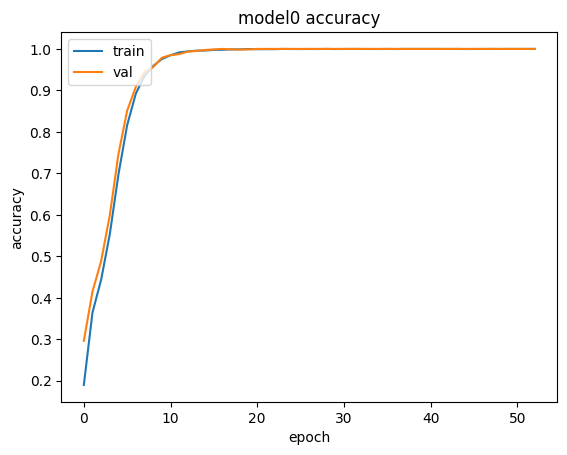

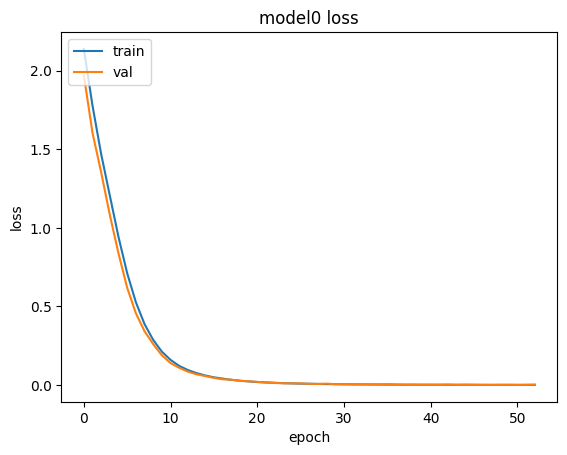

10 examples from test data...
Input          Expected       Predicted         T/F
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[4, 7, 3, 8]   [8, 3, 7, 4]   [8, 3, 7, 4]   True
[3, 7, 7, 5]   [5, 7, 7, 3]   [5, 7, 7, 3]   True
[3, 4, 5, 3]   [3, 5, 4, 3]   [3, 5, 4, 3]   True
[4, 1, 6, 1]   [1, 6, 1, 4]   [1, 6, 1, 4]   True
[3, 4, 7, 1]   [1, 7, 4, 3]   [1, 7, 4, 3]   True
[1, 2, 5, 5]   [5, 5, 2, 1]   [5, 5, 2, 1]   True
[6, 7, 5, 7]   [7, 5, 7, 6]   [7, 5, 7, 6]   True
[7, 3, 4, 1]   [1, 4, 3, 7]   [1, 4, 3, 7]   True
[4, 3, 3, 7]   [7, 3, 3, 4]   [7, 3, 3, 4]   True
[5, 6, 2, 1]   [1, 2, 6, 5]   [1, 2, 6, 5]   True
Accuracy:  1.0


In [217]:
train_test(encoder_decoder_model, [encoder_input_data, decoder_input_data], decoder_predicted_data, [encoder_input_data, decoder_input_data], decoder_predicted_data, epochs=100, batch_size=BATCH_SIZE, patience=5, verbose=1)

Now we can inference this model as same as before